# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_144  A0A087WYK9;Q02985;Q02985-2;Q6NSD3   16.364
Sample_186  Q92520                              20.906
Sample_053  P98160                              19.565
Sample_118  H0YEX9;P57087;P57087-3              16.648
Sample_121  P01019                              21.286
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_003  O95881            11.290
Sample_208  P16519;P16519-3   15.628
Sample_030  Q09328            14.633
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.003
            A0A075B6Q5                 12.278
            A0A075B6R2                 12.370
            A0A075B6S5                 12.921
            A0A087WSY4                 13.675
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.443
            Q9UI40;Q9UI40-2            12.253
            Q9UIW2                     12.147
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.378
            Q9UP79                     12.432
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.396,15.050,16.842,19.863,15.944,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.821,19.067,...,15.528,15.576,14.228,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.065,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.214,17.705,17.039,16.037,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.595,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.324,15.345,17.084,18.708,14.249,19.433,11.419,11.093
Sample_207,15.739,16.877,15.469,16.898,14.678,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.003,...,16.012,15.178,12.912,15.050,16.842,19.863,12.612,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.415,19.067,16.188,...,15.528,15.576,11.294,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.027,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.445,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.275,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.451,15.345,17.084,18.708,14.249,19.433,13.010,11.974
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 313.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.21it/s]

100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.24it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.10it/s]

100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.25it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.61it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.17it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.26it/s]

100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.58it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.77it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.38it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.17it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.11it/s]

100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.59it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.23it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.21it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.68it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.25it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.06it/s]

100%|██████████| 8/8 [00:03<00:00,  1.92it/s]

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.13it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.64it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.25it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.28it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.51it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.64it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.76it/s]

100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.88it/s]

 30%|███       | 3/10 [00:00<00:01,  3.65it/s]

 40%|████      | 4/10 [00:01<00:01,  3.10it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.95it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.92it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.03it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.13it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.21it/s]

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.46it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.57it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.99it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.50it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.09it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.65it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.41it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.16it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.31it/s]

100%|██████████| 11/11 [00:03<00:00,  2.39it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.09it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.13it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.55it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.33it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.42it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.46it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.54it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.44it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.15it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.20it/s]

100%|██████████| 12/12 [00:05<00:00,  2.03it/s]

100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.12it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.94it/s]

 31%|███       | 4/13 [00:01<00:02,  3.47it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.19it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.92it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.43it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.21it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.24it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.16it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.21it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.43it/s]

100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.69it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.23it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.70it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.60it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.51it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.59it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.74it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.59it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.77it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.83it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.78it/s]

100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.58it/s]

 20%|██        | 3/15 [00:01<00:04,  2.85it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.60it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.77it/s]

 40%|████      | 6/15 [00:02<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.98it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.94it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.89it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.88it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.79it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.48it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.32it/s]

100%|██████████| 15/15 [00:05<00:00,  2.11it/s]

100%|██████████| 15/15 [00:05<00:00,  2.60it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.053 0.014          0.754 0.355       0.113   
2             0.004 0.002      0.054 0.018          0.702 0.096       0.599   
3             0.004 0.002      0.045 0.017          0.698 0.113       0.592   
4             0.004 0.002      0.055 0.016          0.673 0.092       0.641   
5             0.005 0.004      0.067 0.032          0.690 0.099       0.677   
6             0.005 0.004      0.056 0.016          0.789 0.091       0.789   
7             0.006 0.004      0.066 0.030          0.794 0.087       0.796   
8             0.005 0.005      0.054 0.016          0.796 0.087       0.802   
9             0.005 0.004      0.051 0.019          0.791 0.074       0.831   
10            0.007 0.005      0.083 0.028          0.791 0.075       0.833   
11            0.006 0.004      0.067 0.030          0.795 0.078       0.823   
12            0.005 0.004      0.056 0.017          0.804 0.079       0.816   
13            0.006 0.004      0.073 0.023          0.802 0.084       0.820   
14            0.006 0.004      0.071 0.029          0.797 0.085       0.811   
15            0.005 0.004      0.062 0.023          0.794 0.083       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.189 0.126                  0.549 0.039        0.845   
2          0.102   0.641 0.082                  0.704 0.062        0.777   
3          0.113   0.633 0.088                  0.698 0.066        0.780   
4          0.112   0.649 0.079                  0.704 0.062        0.779   
5          0.116   0.677 0.081                  0.724 0.066        0.792   
6          0.117   0.783 0.081                  0.815 0.068        0.888   
7          0.111   0.790 0.076                  0.821 0.065        0.887   
8          0.105   0.794 0.074                  0.824 0.063        0.891   
9          0.096   0.807 0.063                  0.834 0.056        0.908   
10         0.095   0.808 0.063                  0.835 0.056        0.907   
11         0.100   0.805 0.067                  0.833 0.059        0.905   
12         0.101   0.806 0.067                  0.834 0.057        0.913   
13         0.100   0.807 0.070                  0.835 0.060        0.911   
14         0.098   0.799 0.067                  0.828 0.057        0.909   
15         0.098   0.796 0.068                  0.825 0.058        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.813 0.095        210.000 0.000  
2          0.073                  0.753 0.089        210.000 0.000  
3          0.072                  0.728 0.099        210.000 0.000  
4          0.071                  0.728 0.096        210.000 0.000  
5          0.068                  0.754 0.098        210.000 0.000  
6          0.054                  0.850 0.071        210.000 0.000  
7          0.053                  0.849 0.070        210.000 0.000  
8          0.053                  0.863 0.065        210.000 0.000  
9          0.049                  0.896 0.048        210.000 0.000  
10         0.049                  0.896 0.050        210.000 0.000  
11         0.050                  0.893 0.051        210.000 0.000  
12         0.050                  0.905 0.048        210.000 0.000  
13         0.051                  0.902 0.049        210.000 0.000  
14         0.051                  0.900 0.049        210.000 0.000  
15         0.052                  0.898 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 430.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.33it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.78it/s]

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.63it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.17it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.98it/s]

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.67it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.92it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.26it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  2.66it/s]

100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.40it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.01it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.32it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.22it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.55it/s]

100%|██████████| 7/7 [00:02<00:00,  2.30it/s]

100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.88it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.68it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.87it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.73it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.79it/s]

100%|██████████| 8/8 [00:03<00:00,  1.89it/s]

100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.43it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.29it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.37it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.43it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.50it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.41it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.48it/s]

100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.79it/s]

 30%|███       | 3/10 [00:00<00:01,  3.59it/s]

 40%|████      | 4/10 [00:01<00:01,  3.17it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.11it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.04it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.01it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.00it/s]

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.30it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.60it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.58it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.37it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.19it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.91it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.90it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.56it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.23it/s]

100%|██████████| 11/11 [00:04<00:00,  2.07it/s]

100%|██████████| 11/11 [00:04<00:00,  2.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.28it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.39it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.69it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.24it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.02it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.68it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.32it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.01it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.87it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.89it/s]

100%|██████████| 12/12 [00:04<00:00,  2.12it/s]

100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.35it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.92it/s]

 31%|███       | 4/13 [00:01<00:03,  2.40it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.14it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.11it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.12it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.03it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.13it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.00it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.12it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.22it/s]

100%|██████████| 13/13 [00:05<00:00,  2.28it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.54it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.92it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.71it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.47it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.41it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.25it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.25it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.26it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.28it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.32it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.36it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.48it/s]

100%|██████████| 14/14 [00:05<00:00,  2.53it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

 20%|██        | 3/15 [00:00<00:03,  3.57it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.71it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.39it/s]

 40%|████      | 6/15 [00:02<00:03,  2.38it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.20it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.32it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.38it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.44it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.53it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.60it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.57it/s]

100%|██████████| 15/15 [00:05<00:00,  2.60it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.060 0.021          0.000 0.000       0.000   
2             0.005 0.005      0.071 0.025          0.699 0.111       0.516   
3             0.007 0.006      0.062 0.024          0.688 0.105       0.507   
4             0.004 0.002      0.057 0.021          0.735 0.116       0.571   
5             0.005 0.004      0.061 0.025          0.694 0.090       0.638   
6             0.006 0.005      0.084 0.030          0.692 0.082       0.634   
7             0.005 0.004      0.060 0.021          0.722 0.094       0.638   
8             0.004 0.001      0.051 0.017          0.720 0.089       0.638   
9             0.005 0.003      0.059 0.019          0.773 0.084       0.779   
10            0.006 0.005      0.064 0.020          0.772 0.082       0.781   
11            0.006 0.005      0.064 0.025          0.786 0.084       0.785   
12            0.005 0.003      0.058 0.018          0.791 0.084       0.771   
13            0.004 0.002      0.054 0.016          0.790 0.087       0.762   
14            0.006 0.004      0.066 0.024          0.790 0.084       0.756   
15            0.007 0.007      0.071 0.027          0.788 0.082       0.760   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.853   
2          0.131   0.584 0.109                  0.675 0.072        0.732   
3          0.138   0.573 0.108                  0.667 0.070        0.722   
4          0.115   0.636 0.096                  0.709 0.066        0.776   
5          0.113   0.660 0.087                  0.716 0.067        0.788   
6          0.115   0.657 0.088                  0.715 0.064        0.783   
7          0.122   0.672 0.093                  0.729 0.069        0.790   
8          0.118   0.671 0.089                  0.728 0.066        0.788   
9          0.119   0.771 0.080                  0.805 0.066        0.887   
10         0.123   0.770 0.077                  0.805 0.062        0.890   
11         0.121   0.778 0.074                  0.812 0.061        0.897   
12         0.112   0.775 0.073                  0.809 0.060        0.899   
13         0.117   0.770 0.079                  0.805 0.064        0.898   
14         0.117   0.767 0.078                  0.803 0.063        0.899   
15         0.116   0.768 0.077                  0.804 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.087        210.000 0.000  
2          0.077                  0.666 0.095        210.000 0.000  
3          0.074                  0.658 0.092        210.000 0.000  
4          0.070                  0.747 0.088        210.000 0.000  
5          0.067                  0.750 0.088        210.000 0.000  
6          0.069                  0.747 0.090        210.000 0.000  
7          0.075                  0.748 0.095        210.000 0.000  
8          0.073                  0.748 0.093        210.000 0.000  
9          0.053                  0.857 0.064        210.000 0.000  
10         0.052                  0.859 0.062        210.000 0.000  
11         0.050                  0.872 0.057        210.000 0.000  
12         0.050                  0.878 0.057        210.000 0.000  
13         0.049                  0.875 0.058        210.000 0.000  
14         0.048                  0.876 0.058        210.000 0.000  
15         0.048                  0.875 0.057 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1033.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.02it/s]

100%|██████████| 2/2 [00:00<00:00, 16.62it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.21it/s]

100%|██████████| 3/3 [00:00<00:00, 15.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.26it/s]

100%|██████████| 4/4 [00:00<00:00, 14.68it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 29.97it/s]

100%|██████████| 5/5 [00:00<00:00, 22.39it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.11it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.75it/s]

100%|██████████| 6/6 [00:00<00:00, 13.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.92it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 20.85it/s]

100%|██████████| 7/7 [00:00<00:00, 20.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.72it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.55it/s]

100%|██████████| 8/8 [00:00<00:00, 16.89it/s]

100%|██████████| 8/8 [00:00<00:00, 17.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 14.51it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.30it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.05it/s]

100%|██████████| 9/9 [00:00<00:00, 12.70it/s]

100%|██████████| 9/9 [00:00<00:00, 12.49it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.71it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.39it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.39it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.01it/s]

100%|██████████| 10/10 [00:00<00:00, 13.44it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 25.05it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 19.35it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 18.06it/s]

100%|██████████| 11/11 [00:00<00:00, 18.28it/s]

100%|██████████| 11/11 [00:00<00:00, 18.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 27.10it/s]

 50%|█████     | 6/12 [00:00<00:00, 21.75it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 21.20it/s]

100%|██████████| 12/12 [00:00<00:00, 21.25it/s]

100%|██████████| 12/12 [00:00<00:00, 21.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 29.16it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 24.51it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 23.20it/s]

100%|██████████| 13/13 [00:00<00:00, 22.76it/s]

100%|██████████| 13/13 [00:00<00:00, 23.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 26.53it/s]

 50%|█████     | 7/14 [00:00<00:00, 20.78it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 19.49it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 20.44it/s]

100%|██████████| 14/14 [00:00<00:00, 20.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 27.03it/s]

 47%|████▋     | 7/15 [00:00<00:00, 17.31it/s]

 60%|██████    | 9/15 [00:00<00:00, 18.10it/s]

 80%|████████  | 12/15 [00:00<00:00, 19.00it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 19.00it/s]

100%|██████████| 15/15 [00:00<00:00, 18.95it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.071 0.029          0.000 0.000       0.000   
2             0.005 0.005      0.069 0.026          0.608 0.121       0.471   
3             0.007 0.007      0.075 0.032          0.685 0.132       0.534   
4             0.005 0.003      0.056 0.018          0.690 0.141       0.542   
5             0.005 0.004      0.067 0.028          0.631 0.137       0.493   
6             0.004 0.001      0.057 0.018          0.666 0.108       0.567   
7             0.002 0.000      0.028 0.001          0.672 0.096       0.574   
8             0.004 0.000      0.047 0.007          0.670 0.105       0.571   
9             0.004 0.002      0.048 0.007          0.657 0.099       0.566   
10            0.004 0.001      0.044 0.007          0.651 0.102       0.568   
11            0.003 0.001      0.040 0.009          0.656 0.095       0.571   
12            0.003 0.001      0.030 0.007          0.660 0.098       0.608   
13            0.003 0.001      0.031 0.007          0.659 0.092       0.612   
14            0.003 0.000      0.031 0.012          0.657 0.089       0.614   
15            0.002 0.000      0.028 0.002          0.661 0.092       0.597   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.744   
2          0.106   0.526 0.099                  0.623 0.073        0.731   
3          0.125   0.593 0.114                  0.676 0.078        0.748   
4          0.123   0.600 0.117                  0.680 0.082        0.751   
5          0.128   0.544 0.109                  0.638 0.074        0.773   
6          0.108   0.606 0.090                  0.677 0.068        0.794   
7          0.106   0.613 0.079                  0.683 0.058        0.802   
8          0.106   0.609 0.082                  0.679 0.064        0.795   
9          0.109   0.602 0.084                  0.673 0.062        0.791   
10         0.112   0.600 0.087                  0.670 0.064        0.788   
11         0.115   0.603 0.090                  0.674 0.064        0.784   
12         0.120   0.627 0.094                  0.689 0.071        0.793   
13         0.110   0.629 0.084                  0.689 0.064        0.788   
14         0.106   0.630 0.082                  0.689 0.065        0.786   
15         0.114   0.622 0.088                  0.686 0.066        0.788   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.689 0.082        210.000 0.000  
2          0.082                  0.636 0.103        210.000 0.000  
3          0.074                  0.690 0.103        210.000 0.000  
4          0.077                  0.691 0.104        210.000 0.000  
5          0.069                  0.699 0.097        210.000 0.000  
6          0.062                  0.740 0.083        210.000 0.000  
7          0.063                  0.748 0.086        210.000 0.000  
8          0.065                  0.740 0.090        210.000 0.000  
9          0.065                  0.737 0.089        210.000 0.000  
10         0.067                  0.732 0.092        210.000 0.000  
11         0.065                  0.735 0.081        210.000 0.000  
12         0.064                  0.741 0.077        210.000 0.000  
13         0.063                  0.736 0.078        210.000 0.000  
14         0.064                  0.733 0.080        210.000 0.000  
15         0.064                  0.738 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,15,3
score_time,10,6,3
test_precision,12,12,4
test_recall,10,11,14
test_f1,10,11,14
test_balanced_accuracy,10,11,13
test_roc_auc,12,12,7
test_average_precision,12,12,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.08it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.28it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.48it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.01it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.85it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.01it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.07it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  3.97it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.06it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.21it/s]

100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 29.08it/s]

100%|██████████| 7/7 [00:00<00:00, 23.40it/s]

100%|██████████| 7/7 [00:00<00:00, 24.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.16it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.26it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.19it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.85it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.79it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.95it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.06it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.10it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.15it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  5.13it/s]

100%|██████████| 12/12 [00:02<00:00,  4.95it/s]

100%|██████████| 12/12 [00:02<00:00,  5.06it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


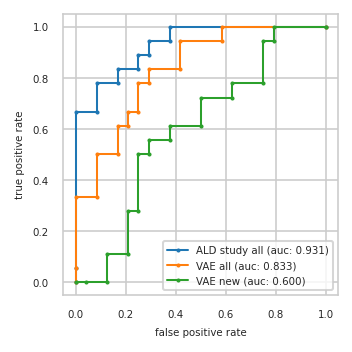

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.667   0.000 0.333   0.125 0.000
3          0.083 0.667   0.083 0.333   0.125 0.111
4          0.083 0.778   0.083 0.500   0.208 0.111
5          0.167 0.778   0.167 0.500   0.208 0.278
6          0.167 0.833   0.167 0.611   0.250 0.278
7          0.250 0.833   0.208 0.611   0.250 0.500
8          0.250 0.889   0.208 0.667   0.292 0.500
9          0.292 0.889   0.250 0.667   0.292 0.556
10         0.292 0.944   0.250 0.778   0.375 0.556
11         0.375 0.944   0.292 0.778   0.375 0.611
12         0.375 1.000   0.292 0.833   0.500 0.611
13         1.000 1.000   0.417 0.833   0.500 0.722
14           NaN   NaN   0.417 0.944   0.625 0.722
15           NaN   NaN   0.583 0.944   0.625 0.778
16           NaN   NaN   0.583 1.000   0.750 0.778
17           NaN   NaN   1.000 1.000   0.750 0.944
18           NaN   NaN     NaN   NaN   0.792 0.944
19           NaN   NaN     NaN   NaN   0.792 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q92765,H0Y7T8;P49418;P49418-2
2,P09486,A0A0G2JQD2;A0A0G2JQM0;A0A0G2JRN4;P30711,Q9NUQ9
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,P31321
4,P14174,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P10636-2;P10636-6,P14174,Q96GD0
6,P61981,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q6EMK4,Q14894,None
8,P14618,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


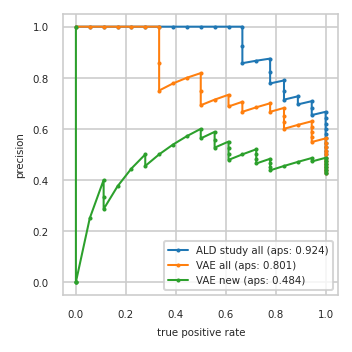

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.548 0.944     0.452 0.778
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.667 1.000     0.630 0.944     0.481 0.722
16         0.654 0.944     0.615 0.889     0.500 0.722
17         0.680 0.944     0.600 0.833     0.520 0.722
18         0.708 0.944     0.625 0.833     0.500 0.667
19         0.696 0.889     0.652 0.833     0.478 0.611
20         0.727 0.889     0.682 0.833     0.500 0.611
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.875 0.778     0.688 0.611     0.562 0.500
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.923 0.667     0.692 0.500     0.538 0.389
30         1.000 0.667     0.750 0.500     0.500 0.333
31         1.000 0.611     0.818 0.500     0.455 0.278
32         1.000 0.556     0.800 0.444     0.500 0.278
33         1.000 0.500     0.778 0.389     0.444 0.222
34         1.000 0.444     0.750 0.333     0.375 0.167
35         1.000 0.389     0.857 0.333     0.286 0.111
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.000 0.000
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


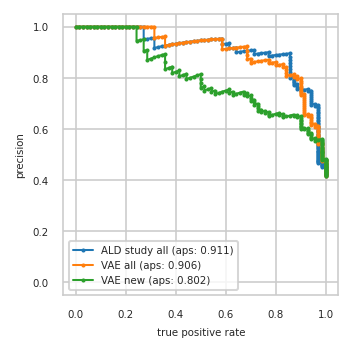

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


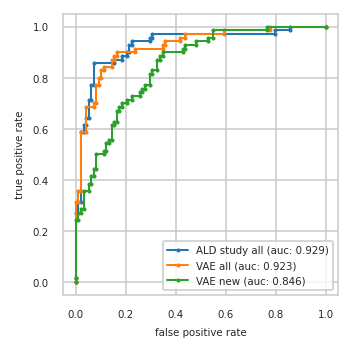

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}